In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Dataset

In [3]:
gtsrb_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

In [4]:
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, class_to_idx=None, classes=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

        if class_to_idx is not None:
            self.classes=classes
            self.class_to_idx = class_to_idx
        else:
            self.classes = sorted(self.annotations['ClassId'].unique())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 7])
        image = Image.open(img_path).convert('RGB')
        
        class_id = self.annotations.iloc[idx, 6]
        class_idx = self.class_to_idx[class_id]

        if self.transform:
            image = self.transform(image)

        return image, class_idx

In [5]:
train_dir = os.path.join(gtsrb_path, 'Train')
test_dir = os.path.join(gtsrb_path, 'Test')
train_csv = os.path.join(gtsrb_path, 'Train.csv')
test_csv = os.path.join(gtsrb_path, 'Test.csv')

train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])
    
val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

train_dataset = GTSRBDataset(gtsrb_path, train_csv, transform=train_transforms, class_to_idx=None)
val_dataset = GTSRBDataset(gtsrb_path, test_csv, transform=val_transforms, class_to_idx=train_dataset.class_to_idx, classes=train_dataset.classes)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True, 
    # num_workers=4
)
    
val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False, 
    # num_workers=4
)

num_classes = len(train_dataset.classes)

# Training 

In [6]:
def train_model(model_name, model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5, patience=5, device='cpu', inputs_requires_grad=False):
    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
        'epoch_time': []
    }
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs.requires_grad = inputs_requires_grad
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100.0 * train_correct / train_total

        # validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
                
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100.0 * val_correct / val_total

        scheduler.step(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['lr'].append(current_lr)
        
        # print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print("-" * 60)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
        else:
            counter += 1
            print(f'No improvement for {counter} epochs.')
            
            if counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))
    
    return model, history

# Base CNN

In [9]:
base_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

base_cnn

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2048, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=512, out_features=256, bias=True)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_cnn.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

base_cnn_best_model, history = train_model(
    model_name="base_cnn",
    model=base_cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50,
    patience=6,
    device='cuda'
)

Epoch 1/50
Train Loss: 1.9661, Train Acc: 39.37%
Val Loss: 0.7986, Val Acc: 74.28%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/50
Train Loss: 0.5949, Train Acc: 79.67%
Val Loss: 0.2856, Val Acc: 92.25%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/50
Train Loss: 0.3045, Train Acc: 90.06%
Val Loss: 0.2113, Val Acc: 93.65%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 4/50
Train Loss: 0.2148, Train Acc: 93.25%
Val Loss: 0.1670, Val Acc: 95.35%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 5/50
Train Loss: 0.1712, Train Acc: 94.64%
Val Loss: 0.1528, Val Acc: 95.91%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 6/50
Train Loss: 0.1460, Train Acc: 95.60%
Val Loss: 0.1435, Val Acc: 96.02%
Learning Rate: 0.001000
-----------------------------------------------------

C:\Users\joao_\AppData\Local\Temp\ipykernel_5184\533071635.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}_model.pt

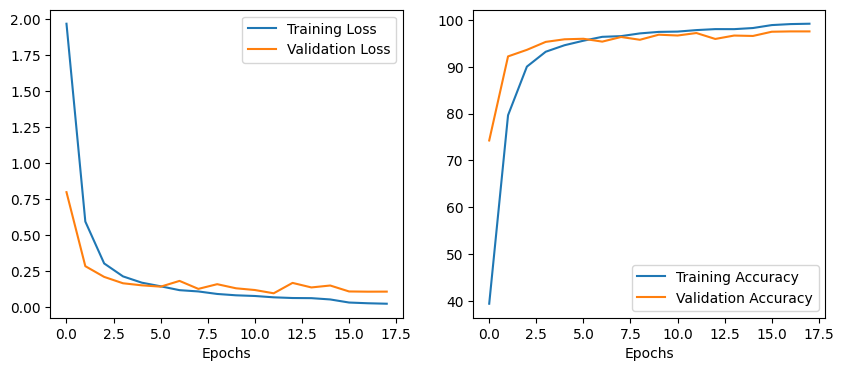

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].legend()

# Inference

In [18]:
def inference(model, image, device='cpu'):
    model.eval()
    model = model.to(device)

    if not isinstance(image, torch.Tensor):
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
        ])
        image = transform(image)

    if image.dim() == 3:
            image = image.unsqueeze(0)

    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item()

In [32]:
meta_dir = os.path.join(gtsrb_path, 'Meta')
meta_csv = os.path.join(gtsrb_path, 'Meta.csv')

meta_data = pd.read_csv(meta_csv)

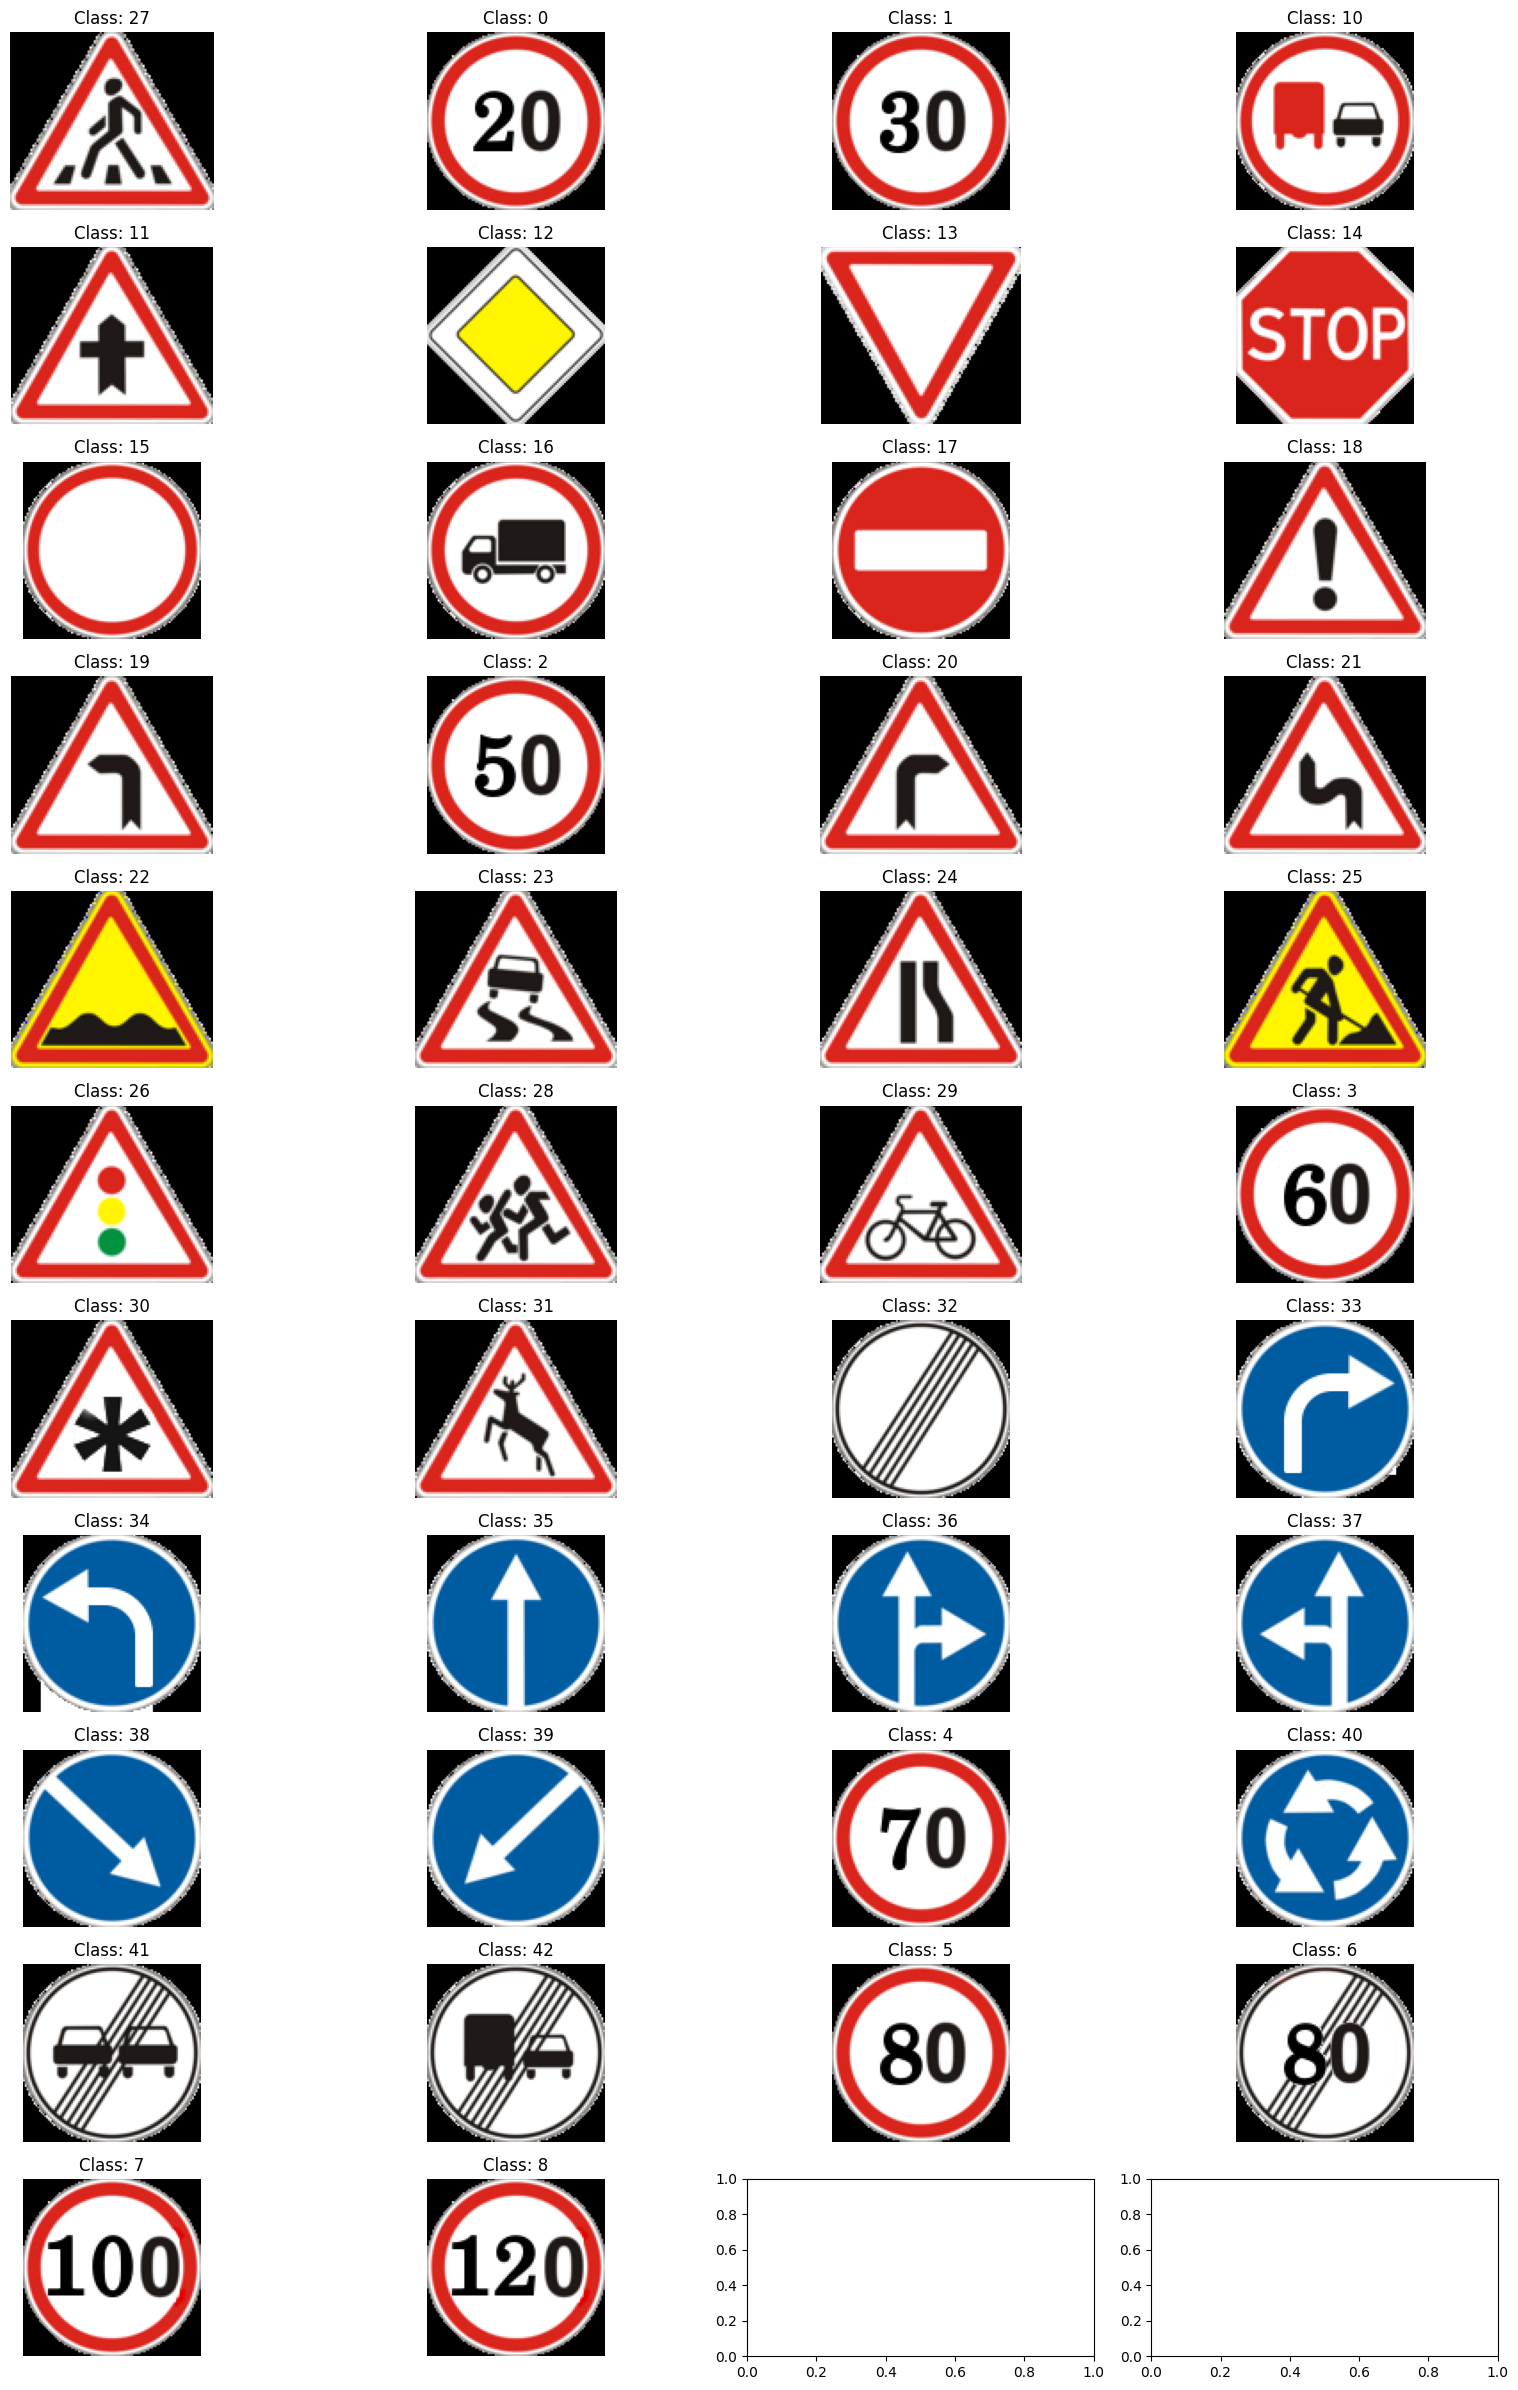

In [137]:
fg, ax = plt.subplots(11, 4, figsize=(16, 24))
ax = ax.flatten()

for i in range(42):
    img_path = os.path.join(gtsrb_path, meta_data.iloc[i, 0])
    image = Image.open(img_path).convert('RGB')
    ax[i].imshow(image)
    ax[i].set_title(f"Class: {meta_data.iloc[i, 1]}")
    ax[i].axis('off')

plt.tight_layout()
plt.show()

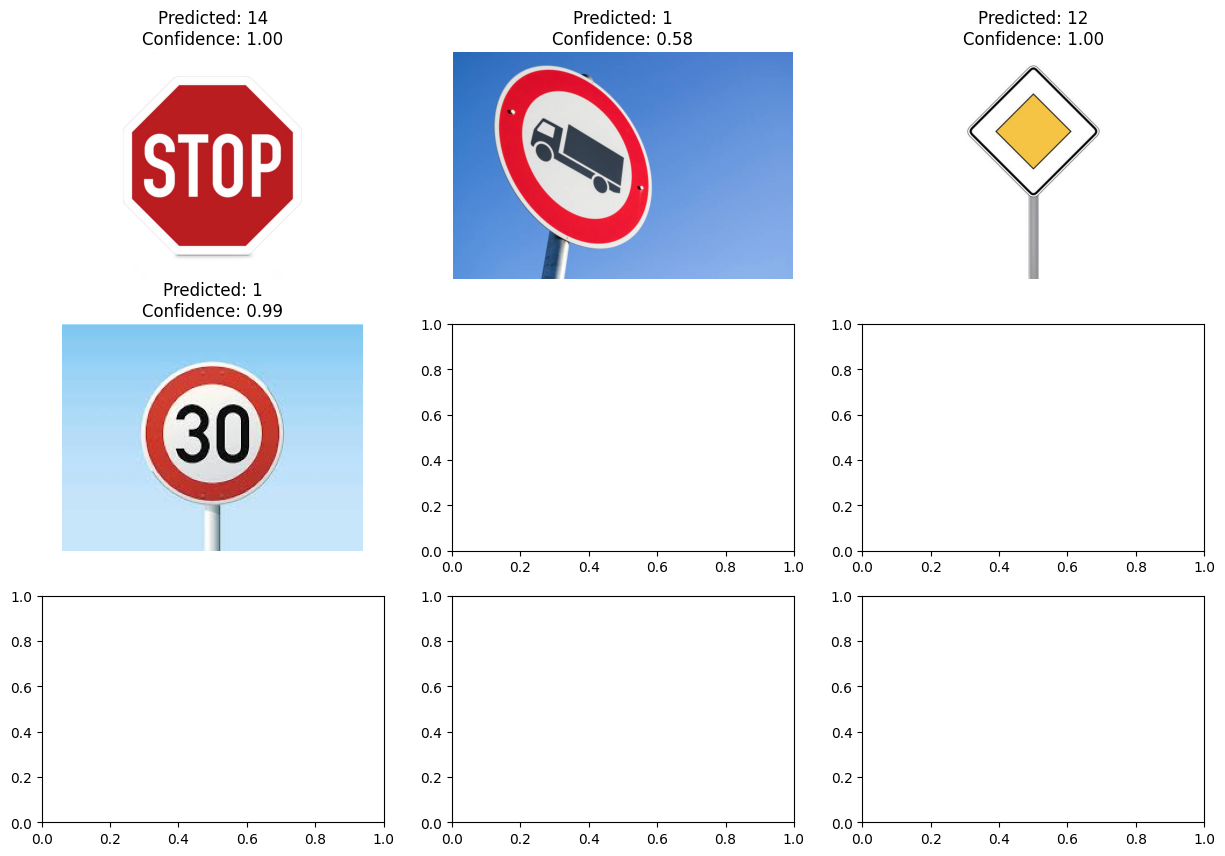

In [148]:
imgs = [
    r"C:\Users\joao_\Downloads\519XNfZVJ4L.jpg",
    r"C:\Users\joao_\Downloads\istockphoto-1640022121-612x612.jpg",
    r"C:\Users\joao_\Downloads\main-qimg-26ca0ce7f170f19ec18b77f8881cd203-lq.jpg",
    r"C:\Users\joao_\Downloads\images (3).jpg",
]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')
    
    pred_class_n, probs = inference(base_cnn_best_model, img, device='cuda')
    axs[idx].set_title(f'Predicted: {pred_class_n}\nConfidence: {probs:.2f}')